In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.options.display.float_format = "{:,.4f}".format
plt.style.use('seaborn-v0_8')

In [ ]:
from cmds.portfolio import *

In [ ]:
# Load S&P 500 individual stock returns
spx_file = '../data/spx_returns_weekly.xlsx'
stock_rets = pd.read_excel(spx_file, 's&p500 rets').set_index('date')
bench_rets = pd.read_excel(spx_file, 'benchmark rets').set_index('date')

# Load sector ETF returns
sector_file = '../data/sector_etf_data.xlsx'
sector_rets = pd.read_excel(sector_file, 'total returns').set_index('date')

print(f"Stock returns shape: {stock_rets.shape}")
print(f"Sector returns shape: {sector_rets.shape}")
print(f"Benchmark returns shape: {bench_rets.shape}")

Stock returns shape: (542, 442)
Sector returns shape: (380, 11)
Benchmark returns shape: (542, 7)


In [ ]:
# Align all datasets to common dates
common_dates = stock_rets.index.intersection(sector_rets.index).intersection(bench_rets.index)

# Extract aligned data
stocks = stock_rets.loc[common_dates]
sectors = sector_rets.loc[common_dates]
benchmarks = bench_rets.loc[common_dates]

# Combine sector and benchmark factors (excluding overlapping ETFs)
benchmarks_clean = benchmarks.drop(columns=['SPY','TLT','IYR','BTC'], errors='ignore')
factors = pd.concat([sectors, benchmarks_clean], axis=1)

# Display final dataset information
final_dataset_info = pd.DataFrame({
    'Metric': ['Common Dates', 'Number of Stocks', 'Number of Factors', 'Date Range'],
    'Value': [
        f"{len(common_dates)} observations",
        f"{stocks.shape[1]} stocks", 
        f"{factors.shape[1]} factors",
        f"{common_dates[0].strftime('%Y-%m-%d')} to {common_dates[-1].strftime('%Y-%m-%d')}"
    ]
})
final_dataset_info

Metric                     Value
0       Common Dates          361 observations
1   Number of Stocks                442 stocks
2  Number of Factors                14 factors
3         Date Range  2018-06-29 to 2025-05-23

In [ ]:
TICKS = [
    'AAPL',
    'BRK/B',
    'NVDA',
    'TSLA',
    'V',
    'C',
    'LLY',
    'AMZN',
]

In [ ]:
# Get OLS metrics for factor decomposition
ols_metrics = get_ols_metrics(factors, stocks, annualization=52)
ols_metrics.loc[TICKS].style.format('{:.1%}',na_rep='-')

In [ ]:
# Perform factor decomposition for each stock
USE_INTERCEPT = True

# Initialize results DataFrames
betas = pd.DataFrame(index=stocks.columns, columns=factors.columns, dtype=float)
residuals = pd.DataFrame(index=stocks.index, columns=stocks.columns, dtype=float)
r_squared = pd.Series(index=stocks.columns, dtype=float)

# Prepare factor matrix (with intercept if needed)
X = factors.copy()
if USE_INTERCEPT:
    X = sm.add_constant(X)
    betas.insert(0, 'alpha', 0)

# Run regressions for each stock
for stock in stocks.columns:
    y = stocks[stock]
    results = sm.OLS(y, X).fit()
    betas.loc[stock] = results.params
    residuals[stock] = results.resid
    r_squared[stock] = results.rsquared

# Display regression summary statistics
regression_summary = pd.DataFrame({
    'value': [
        f"{r_squared.mean():.3f}",
        f"{r_squared.median():.3f}",
        f"{r_squared.min():.3f}",
        f"{r_squared.max():.3f}",
        f"{r_squared.std():.3f}"
    ]
}, index=['Average R2', 'Median R2', 'Min R2', 'Max R2', 'Std R2'])

# Find stocks with min and max R2
min_r2_stock = r_squared.idxmin()
max_r2_stock = r_squared.idxmax()

r2_extremes = pd.DataFrame({
    'Stock': [min_r2_stock, max_r2_stock],
    'R2': [f"{r_squared[min_r2_stock]:.3f}", f"{r_squared[max_r2_stock]:.3f}"]
}, index=['Min R2', 'Max R2'])

display(regression_summary)
display(r2_extremes)

value
Average R2  0.571
Median R2   0.570
Min R2      0.123
Max R2      0.899
Std R2      0.152

Stock     R2
Min R2  ERIE  0.123
Max R2   XOM  0.899

***

## Dimension Reduction

In [ ]:
nPCA = 3

# Compare PCA structure between original returns and residuals
pca_stocks = PCA()
pca_resids = PCA()

pca_stocks.fit(stocks)
pca_resids.fit(residuals)

# Calculate cumulative explained variance for first 5 components
stocks_cum_var = np.cumsum(pca_stocks.explained_variance_ratio_[:nPCA] * 100)
resids_cum_var = np.cumsum(pca_resids.explained_variance_ratio_[:nPCA] * 100)

# Create comparison DataFrame
pca_analysis = pd.DataFrame({
    'Stock Returns Explained (%)': [f"{var:.2f}%" for var in stocks_cum_var],
    'Residuals Explained (%)': [f"{var:.2f}%" for var in resids_cum_var]
}, index=[f'PC{i+1}' for i in range(nPCA)])

pca_analysis

Stock Returns Explained (%) Residuals Explained (%)
PC1                      40.75%                   4.81%
PC2                      46.35%                   8.26%
PC3                      50.41%                  11.37%

In [ ]:
# Numerical measures of correlation structure
condition_numbers = pd.DataFrame({
    'Dataset': ['Original Returns', 'Residuals', 'Factors'],
    'Condition Number': [
        f"{np.linalg.cond(stocks.corr()):.1e}",
        f"{np.linalg.cond(residuals.corr()):.1e}", 
        f"{np.linalg.cond(factors.corr()):.1e}"
    ],
    'Determinant': [
        f"{np.linalg.det(stocks.corr()):.1e}",
        f"{np.linalg.det(residuals.corr()):.1e}",
        f"{np.linalg.det(factors.corr()):.1e}"
    ],
    'Average Correlation': [
        f"{stocks.corr().abs().mean().mean():.1%}",
        f"{residuals.corr().abs().mean().mean():.1%}",
        f"{factors.corr().abs().mean().mean():.1%}"
    ]
})

condition_numbers

Dataset Condition Number Determinant Average Correlation
0  Original Returns          1.2e+19    -0.0e+00               39.2%
1         Residuals          4.6e+18     0.0e+00                6.9%
2           Factors          1.0e+02     2.0e-06               50.9%

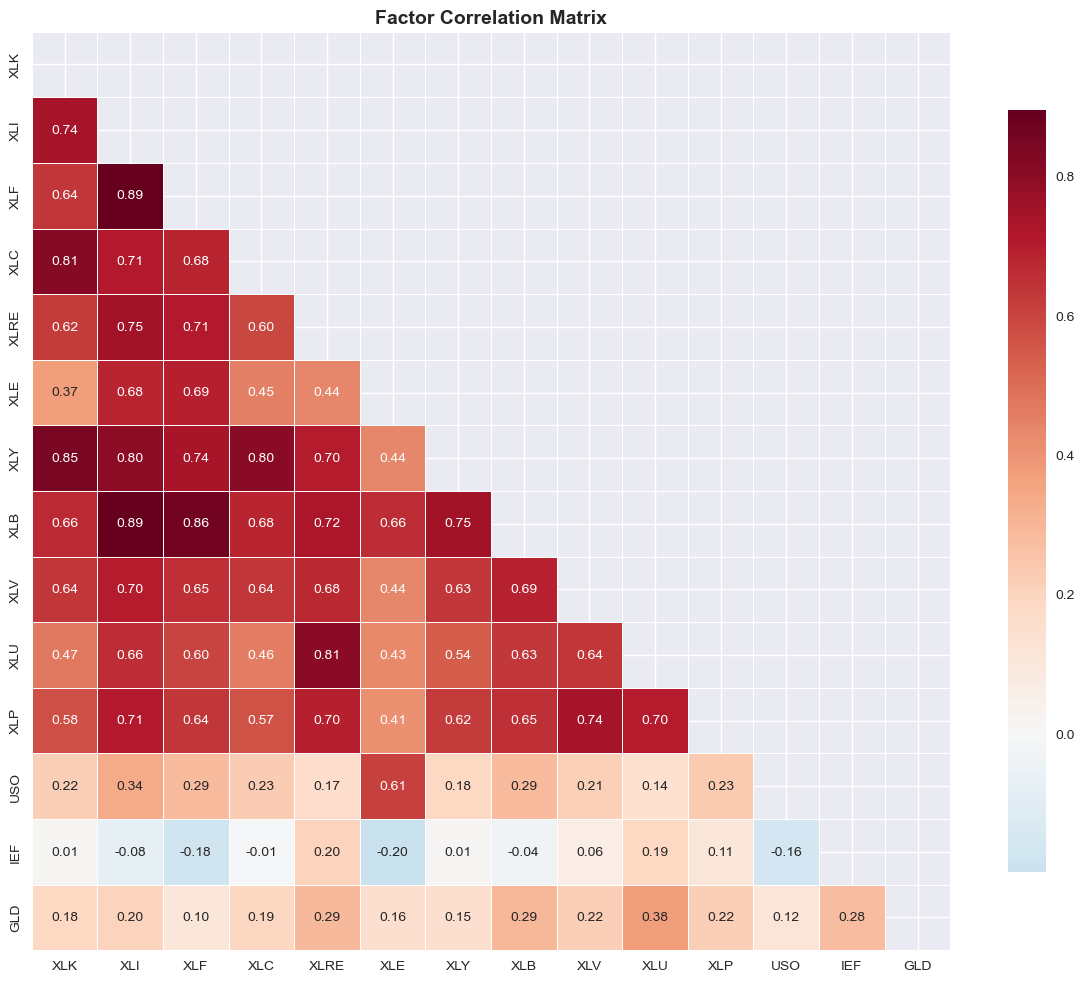

In [ ]:
# Factor correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = factors.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Factor Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

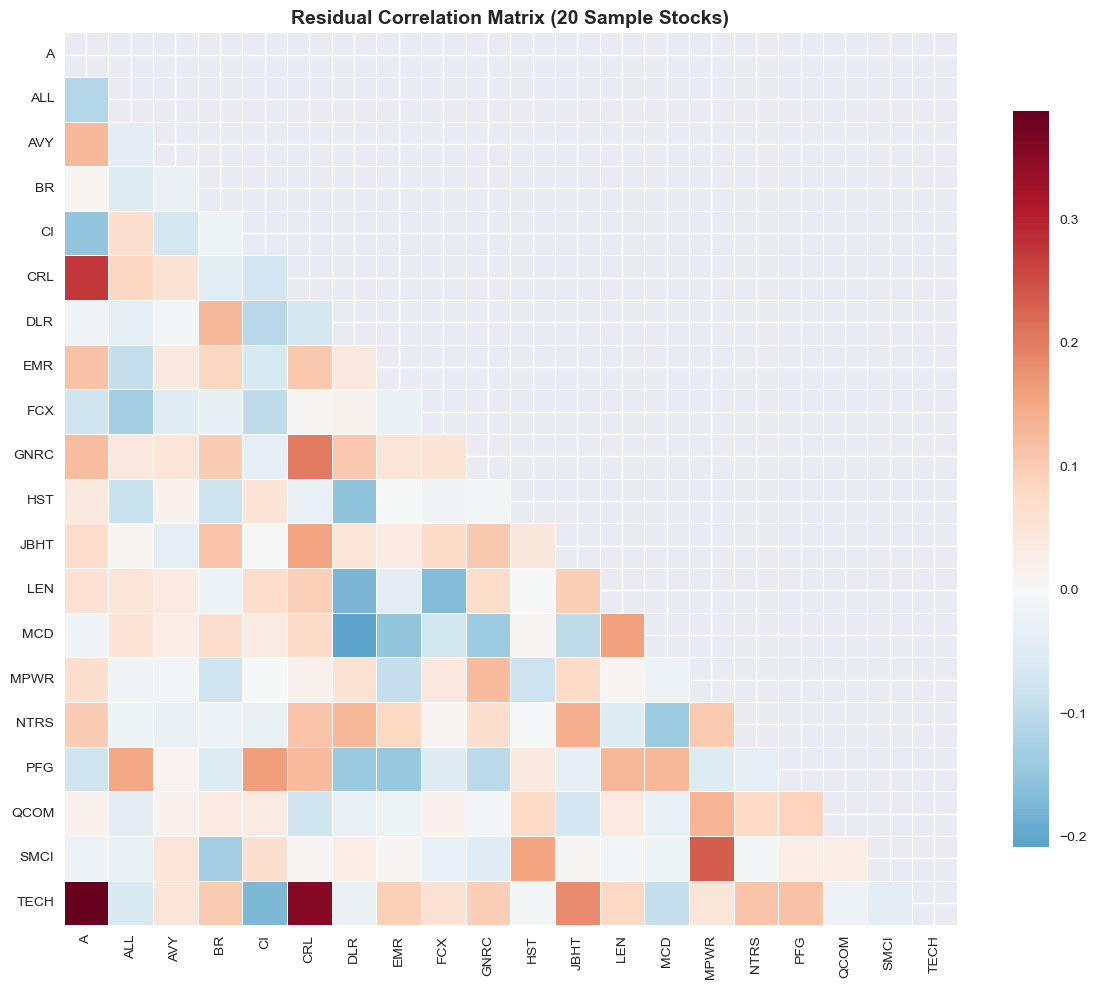

In [ ]:
# Residual correlation heatmap (sample of stocks for readability)
# Get 20 stocks spaced evenly through the list
sample_stocks = residuals.columns[::20][:20]  # Take every 20th stock, up to 20 stocks

plt.figure(figsize=(12, 10))
corr_matrix = residuals.loc[:, sample_stocks].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Residual Correlation Matrix (20 Sample Stocks)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Reduced Risk

In [ ]:
# PRIMARY RESULTS: Key Risk Metrics Comparison

primary_results = pd.DataFrame({
    'Metric': ['Volatility', 'Skewness', 'Kurtosis', 'Average Correlation'],
    'Original Returns': [
        stocks.std().mean(),
        stocks.skew().mean(), 
        stocks.kurtosis().mean(),
        stocks.corr().abs().mean().mean()
    ],
    'Residuals': [
        residuals.std().mean(),
        residuals.skew().mean(),
        residuals.kurtosis().mean(), 
        residuals.corr().abs().mean().mean()
    ],
})

primary_results.set_index('Metric', inplace=True)

primary_results.style.format({
    'Original Returns': '{:.1%}',
    'Residuals': '{:.1%}',
    'Improvement': '{:.4f}'
}, na_rep='-')

primary_results.style.format('{:.1%}',na_rep='-')


In [ ]:
# Load benchmark returns
benchmark = pd.read_excel(spx_file, sheet_name='benchmark rets')
benchmark.set_index('date', inplace=True)

# Calculate metrics for both stocks and residuals
metrics = {}
for metric, func in [('Volatility', lambda x: x.std()), 
                    ('Skewness', lambda x: x.skew()),
                    ('SPY_Correlation', lambda x: pd.Series({col: x[col].corr(benchmark['SPY']) 
                                                           for col in x.columns}))]:
    # Calculate metric for both stocks and residuals
    stocks_metric = func(stocks)
    residuals_metric = func(residuals)
    
    # Create dataframe with describe statistics for this metric
    metric_df = pd.DataFrame({
        'stocks': stocks_metric.describe(),
        'residuals': residuals_metric.describe()
    })
    metrics[metric] = metric_df

# Combine into multilevel dataframe with metrics as top level
stats_df = pd.concat(metrics, axis=1)
stats_df.style.format('{:.1%}',na_rep='-')

In [ ]:
# Summary table of normality improvements across all stocks
all_normality_stats = []

for stock in stocks.columns:
    # Calculate key statistics
    orig_skew = stocks[stock].skew()
    orig_kurt = stocks[stock].kurtosis()
    resid_skew = residuals[stock].skew()
    resid_kurt = residuals[stock].kurtosis()
    
    # Calculate improvement metrics
    skew_improvement = abs(resid_skew) - abs(orig_skew)  # Negative = improvement
    kurt_improvement = abs(resid_kurt) - abs(orig_kurt)  # Negative = improvement
    
    all_normality_stats.append({
        'Stock': stock,
        'Orig_Skew': orig_skew,
        'Resid_Skew': resid_skew,
        'Skew_Change': skew_improvement,
        'Orig_Kurt': orig_kurt,
        'Resid_Kurt': resid_kurt,
        'Kurt_Change': kurt_improvement
    })

normality_summary = pd.DataFrame(all_normality_stats)

# Calculate summary statistics
normality_summary_stats = pd.DataFrame({
    'Metric': [
        'Stocks with Improved Skewness',
        'Stocks with Improved Kurtosis', 
        'Average Skewness Improvement',
        'Average Kurtosis Improvement'
    ],
    'Value': [
        f"{(normality_summary['Skew_Change'] < 0).sum()} / {len(normality_summary)}",
        f"{(normality_summary['Kurt_Change'] < 0).sum()} / {len(normality_summary)}",
        f"{normality_summary['Skew_Change'].mean():.4f}",
        f"{normality_summary['Kurt_Change'].mean():.4f}"
    ]
})
normality_summary_stats

# Show top 10 improvements
top_skew = normality_summary.nsmallest(10, 'Skew_Change')[['Stock', 'Orig_Skew', 'Resid_Skew', 'Skew_Change']]
top_skew


Stock  Orig_Skew  Resid_Skew  Skew_Change
425  WELL     1.8789      0.1516      -1.7272
417   VTR     1.5470      0.2835      -1.2634
230   KIM     1.9671      0.7868      -1.1803
314  PAYX    -1.0960      0.1423      -0.9537
391  TRGP    -1.1758     -0.2274      -0.9484
327    PM    -1.0759     -0.1405      -0.9354
122   DOC     1.0237      0.1174      -0.9063
126   DTE     0.7894     -0.0039      -0.7856
219     J    -0.8223     -0.0422      -0.7801
234   KMI    -0.7983     -0.0694      -0.7288

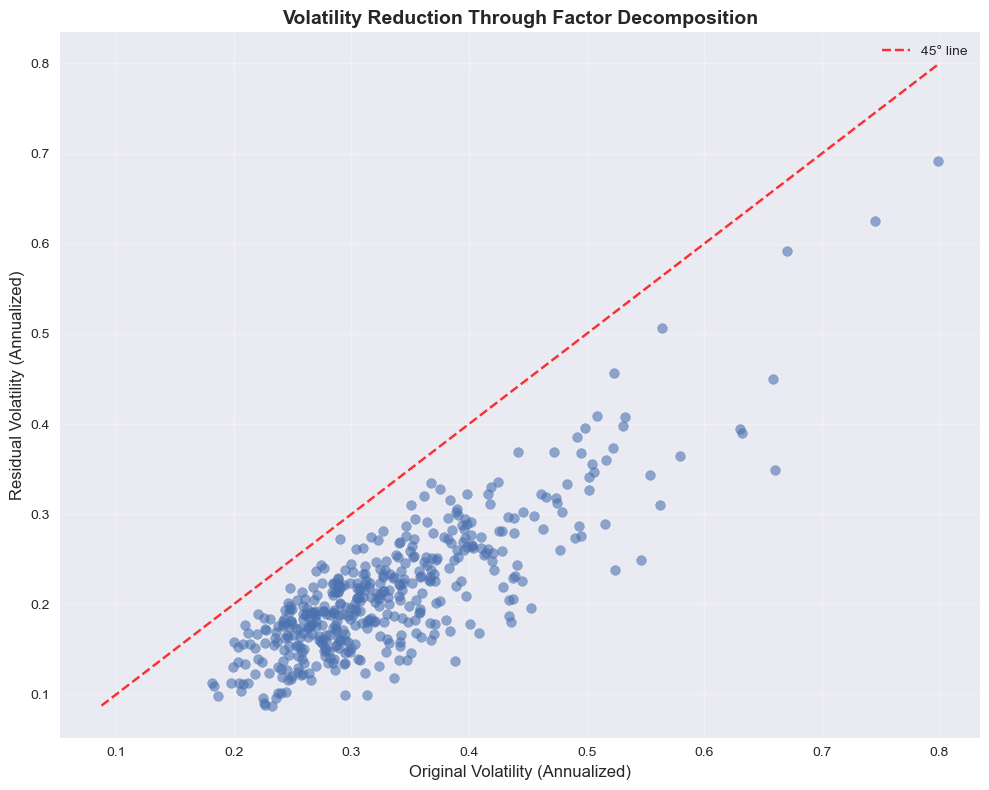

Average volatility reduction: 35.4%


In [ ]:
# Volatility comparison: Original vs Residuals
vols = pd.DataFrame({
    'Original': stocks.std() * np.sqrt(52),
    'Residuals': residuals.std() * np.sqrt(52)
})

fig, ax = plt.subplots(figsize=(10, 8))
x = vols['Original']
y = vols['Residuals']
ax.scatter(x, y, alpha=0.6, s=50)

# Add 45-degree line
min_val = min(min(x), min(y))
max_val = max(max(x), max(y))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='45° line')

ax.set_xlabel('Original Volatility (Annualized)', fontsize=12)
ax.set_ylabel('Residual Volatility (Annualized)', fontsize=12)
ax.set_title('Volatility Reduction Through Factor Decomposition', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average volatility reduction: {(1 - vols['Residuals'].mean() / vols['Original'].mean()) * 100:.1f}%")

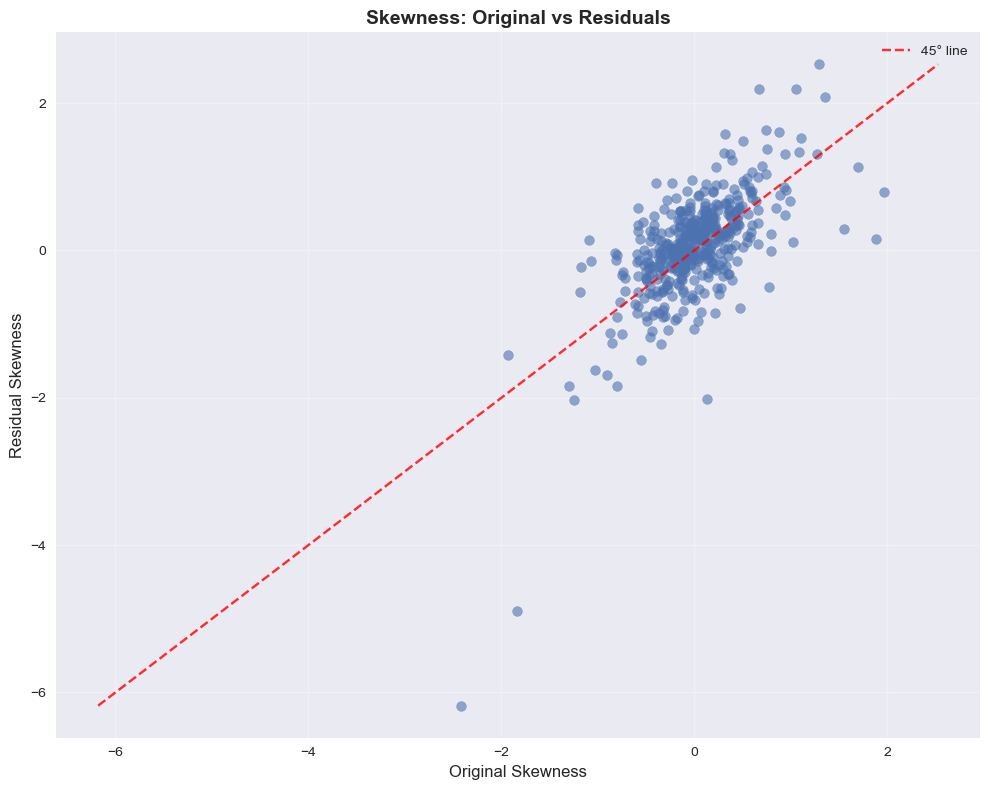

In [ ]:
# Skewness comparison: Original vs Residuals
skews = pd.DataFrame({
    'Original': stocks.skew(),
    'Residuals': residuals.skew()
})

fig, ax = plt.subplots(figsize=(10, 8))
x = skews['Original']
y = skews['Residuals']
ax.scatter(x, y, alpha=0.6, s=50)

# Add 45-degree line
min_val = min(min(x), min(y))
max_val = max(max(x), max(y))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='45° line')

ax.set_xlabel('Original Skewness', fontsize=12)
ax.set_ylabel('Residual Skewness', fontsize=12)
ax.set_title('Skewness: Original vs Residuals', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

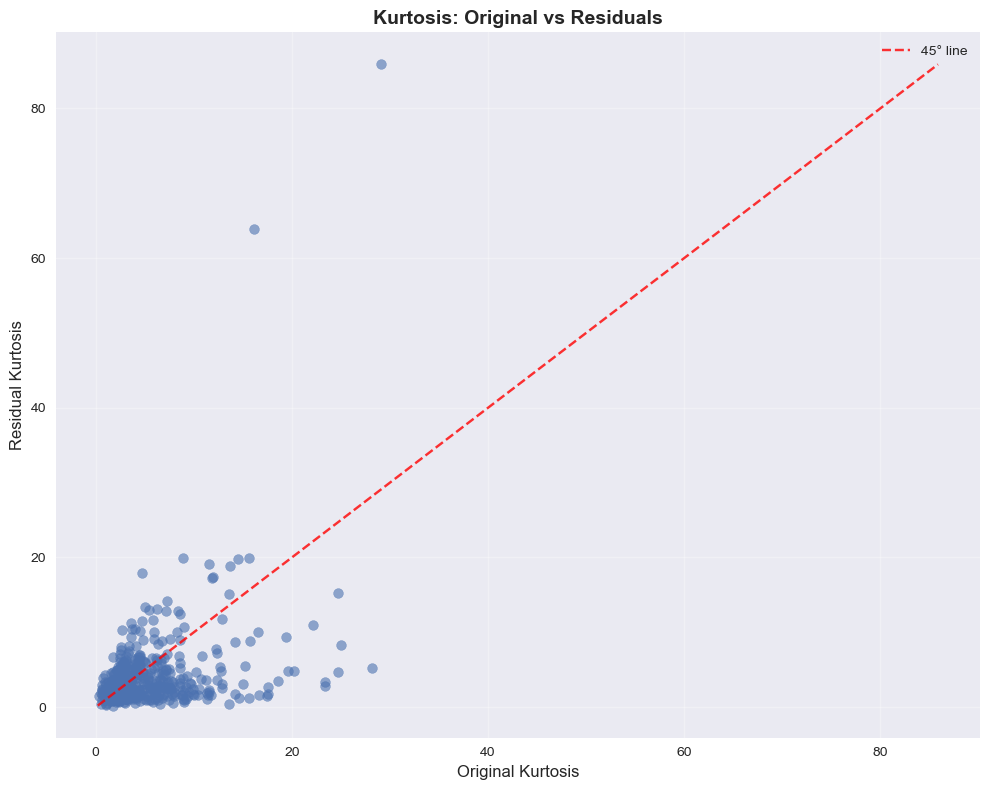

In [ ]:
# Kurtosis comparison: Original vs Residuals
kurts = pd.DataFrame({
    'Original': stocks.kurtosis(),
    'Residuals': residuals.kurtosis()
})

fig, ax = plt.subplots(figsize=(10, 8))
x = kurts['Original']
y = kurts['Residuals']
ax.scatter(x, y, alpha=0.6, s=50)

# Add 45-degree line
min_val = min(min(x), min(y))
max_val = max(max(x), max(y))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='45° line')

ax.set_xlabel('Original Kurtosis', fontsize=12)
ax.set_ylabel('Residual Kurtosis', fontsize=12)
ax.set_title('Kurtosis: Original vs Residuals', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Normality

In [ ]:
# Statistical tests for normality improvement
from scipy.stats import shapiro, jarque_bera, normaltest

# Test normality for a sample of stocks
sample_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
normality_tests = []

for stock in sample_stocks:
    if stock in stocks.columns:
        # Original returns
        orig_stats = {
            'Shapiro-Wilk p-value': shapiro(stocks[stock])[1],
            'Jarque-Bera p-value': jarque_bera(stocks[stock])[1],
            'D\'Agostino p-value': normaltest(stocks[stock])[1]
        }
        
        # Residuals
        resid_stats = {
            'Shapiro-Wilk p-value': shapiro(residuals[stock])[1],
            'Jarque-Bera p-value': jarque_bera(residuals[stock])[1],
            'D\'Agostino p-value': normaltest(residuals[stock])[1]
        }
        
        normality_tests.append({
            'Stock': stock,
            'Original_Shapiro': orig_stats['Shapiro-Wilk p-value'],
            'Residual_Shapiro': resid_stats['Shapiro-Wilk p-value'],
            'Original_JB': orig_stats['Jarque-Bera p-value'],
            'Residual_JB': resid_stats['Jarque-Bera p-value']
        })

normality_df = pd.DataFrame(normality_tests)
normality_df


Stock  Original_Shapiro  Residual_Shapiro  Original_JB  Residual_JB
0   AAPL            0.0001            0.0113       0.0000       0.0001
1   MSFT            0.0021            0.0000       0.0000       0.0000
2  GOOGL            0.0200            0.0000       0.0114       0.0000
3   AMZN            0.0015            0.0001       0.0002       0.0000
4   TSLA            0.0000            0.0000       0.0000       0.0000

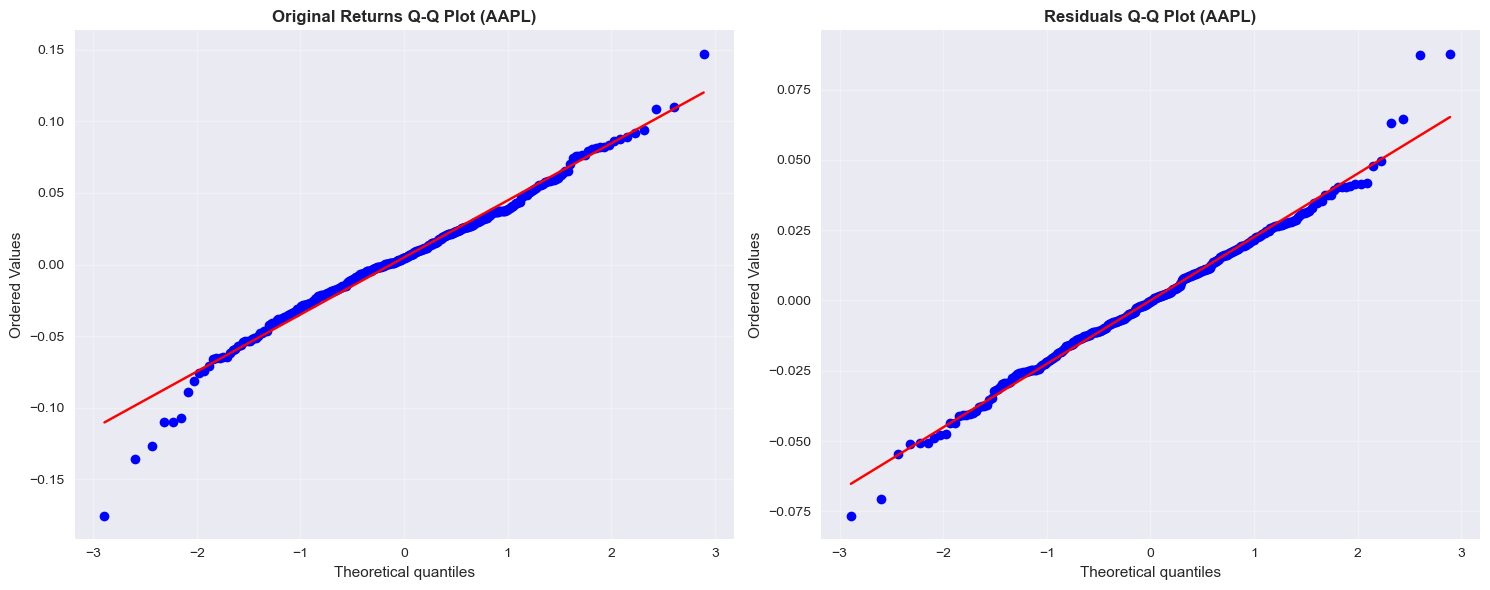

In [ ]:
# Q-Q plots for normality assessment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original returns Q-Q plot
stats.probplot(stocks['AAPL'], dist="norm", plot=ax1)
ax1.set_title("Original Returns Q-Q Plot (AAPL)", fontweight='bold')
ax1.grid(True, alpha=0.3)

# Residuals Q-Q plot
stats.probplot(residuals['AAPL'], dist="norm", plot=ax2)
ax2.set_title("Residuals Q-Q Plot (AAPL)", fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

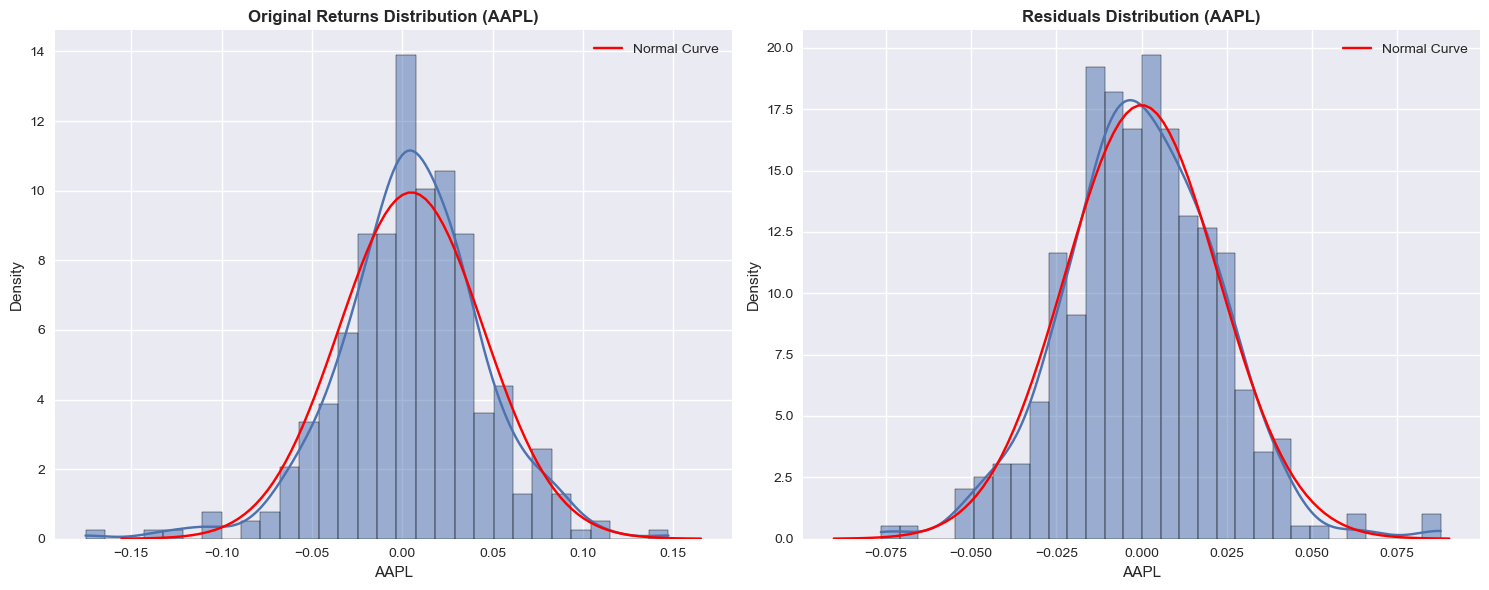

In [ ]:
# Distribution comparison: Original vs Residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original returns distribution
sns.histplot(stocks['AAPL'], kde=True, stat="density", bins=30, ax=ax1)
mean = stocks['AAPL'].mean()
std = stocks['AAPL'].std()
x = np.linspace(mean - 4 * std, mean + 4 * std, 100)
ax1.plot(x, stats.norm.pdf(x, mean, std), label="Normal Curve", color="red")
ax1.set_title("Original Returns Distribution (AAPL)", fontweight='bold')
ax1.legend()

# Residuals distribution
sns.histplot(residuals['AAPL'], kde=True, stat="density", bins=30, ax=ax2)
mean = residuals['AAPL'].mean()
std = residuals['AAPL'].std()
x = np.linspace(mean - 4 * std, mean + 4 * std, 100)
ax2.plot(x, stats.norm.pdf(x, mean, std), label="Normal Curve", color="red")
ax2.set_title("Residuals Distribution (AAPL)", fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Statistical tests for normality improvement
from scipy.stats import shapiro, jarque_bera, normaltest

# Test normality for a sample of stocks
sample_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
normality_tests = []

for stock in sample_stocks:
    if stock in stocks.columns:
        # Original returns
        orig_stats = {
            'Shapiro-Wilk p-value': shapiro(stocks[stock])[1],
            'Jarque-Bera p-value': jarque_bera(stocks[stock])[1],
            'D\'Agostino p-value': normaltest(stocks[stock])[1]
        }
        
        # Residuals
        resid_stats = {
            'Shapiro-Wilk p-value': shapiro(residuals[stock])[1],
            'Jarque-Bera p-value': jarque_bera(residuals[stock])[1],
            'D\'Agostino p-value': normaltest(residuals[stock])[1]
        }
        
        normality_tests.append({
            'Stock': stock,
            'Original_Shapiro': orig_stats['Shapiro-Wilk p-value'],
            'Residual_Shapiro': resid_stats['Shapiro-Wilk p-value'],
            'Original_JB': orig_stats['Jarque-Bera p-value'],
            'Residual_JB': resid_stats['Jarque-Bera p-value']
        })

normality_df = pd.DataFrame(normality_tests)
normality_df


Stock  Original_Shapiro  Residual_Shapiro  Original_JB  Residual_JB
0   AAPL            0.0001            0.0113       0.0000       0.0001
1   MSFT            0.0021            0.0000       0.0000       0.0000
2  GOOGL            0.0200            0.0000       0.0114       0.0000
3   AMZN            0.0015            0.0001       0.0002       0.0000
4   TSLA            0.0000            0.0000       0.0000       0.0000

In [ ]:
# Quantify QQ plot improvements with summary statistics
qq_improvements = []

for stock in sample_stocks:
    if stock in stocks.columns:
        # Calculate theoretical quantiles for comparison
        orig_quantiles = np.percentile(stocks[stock], np.linspace(0.1, 99.9, 100))
        resid_quantiles = np.percentile(residuals[stock], np.linspace(0.1, 99.9, 100))
        
        # Theoretical normal quantiles
        theoretical_quantiles = stats.norm.ppf(np.linspace(0.1, 99.9, 100) / 100)
        
        # Calculate deviations from normality
        orig_deviation = np.mean(np.abs(orig_quantiles - theoretical_quantiles))
        resid_deviation = np.mean(np.abs(resid_quantiles - theoretical_quantiles))
        
        qq_improvements.append({
            'Stock': stock,
            'Original_Deviation': orig_deviation,
            'Residual_Deviation': resid_deviation,
            'Improvement_%': (1 - resid_deviation / orig_deviation) * 100
        })

qq_df = pd.DataFrame(qq_improvements)
qq_df


Stock  Original_Deviation  Residual_Deviation  Improvement_%
0   AAPL              0.7883              0.8010        -1.6212
1   MSFT              0.7920              0.8061        -1.7901
2  GOOGL              0.7873              0.8012        -1.7632
3   AMZN              0.7852              0.7997        -1.8535
4   TSLA              0.7485              0.7736        -3.3470

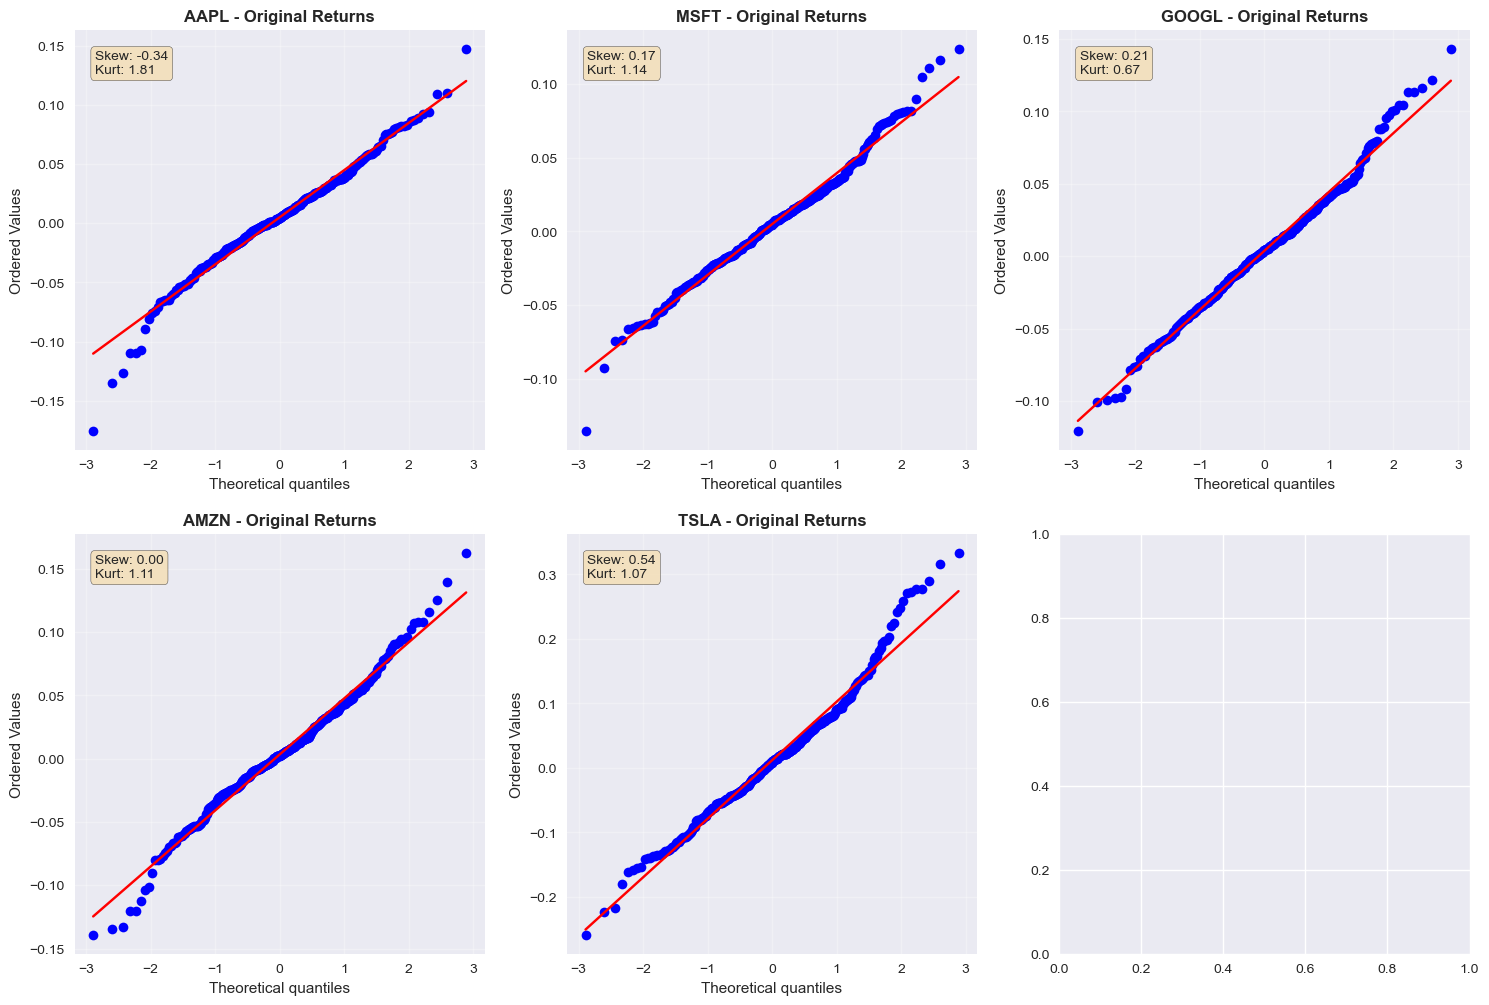

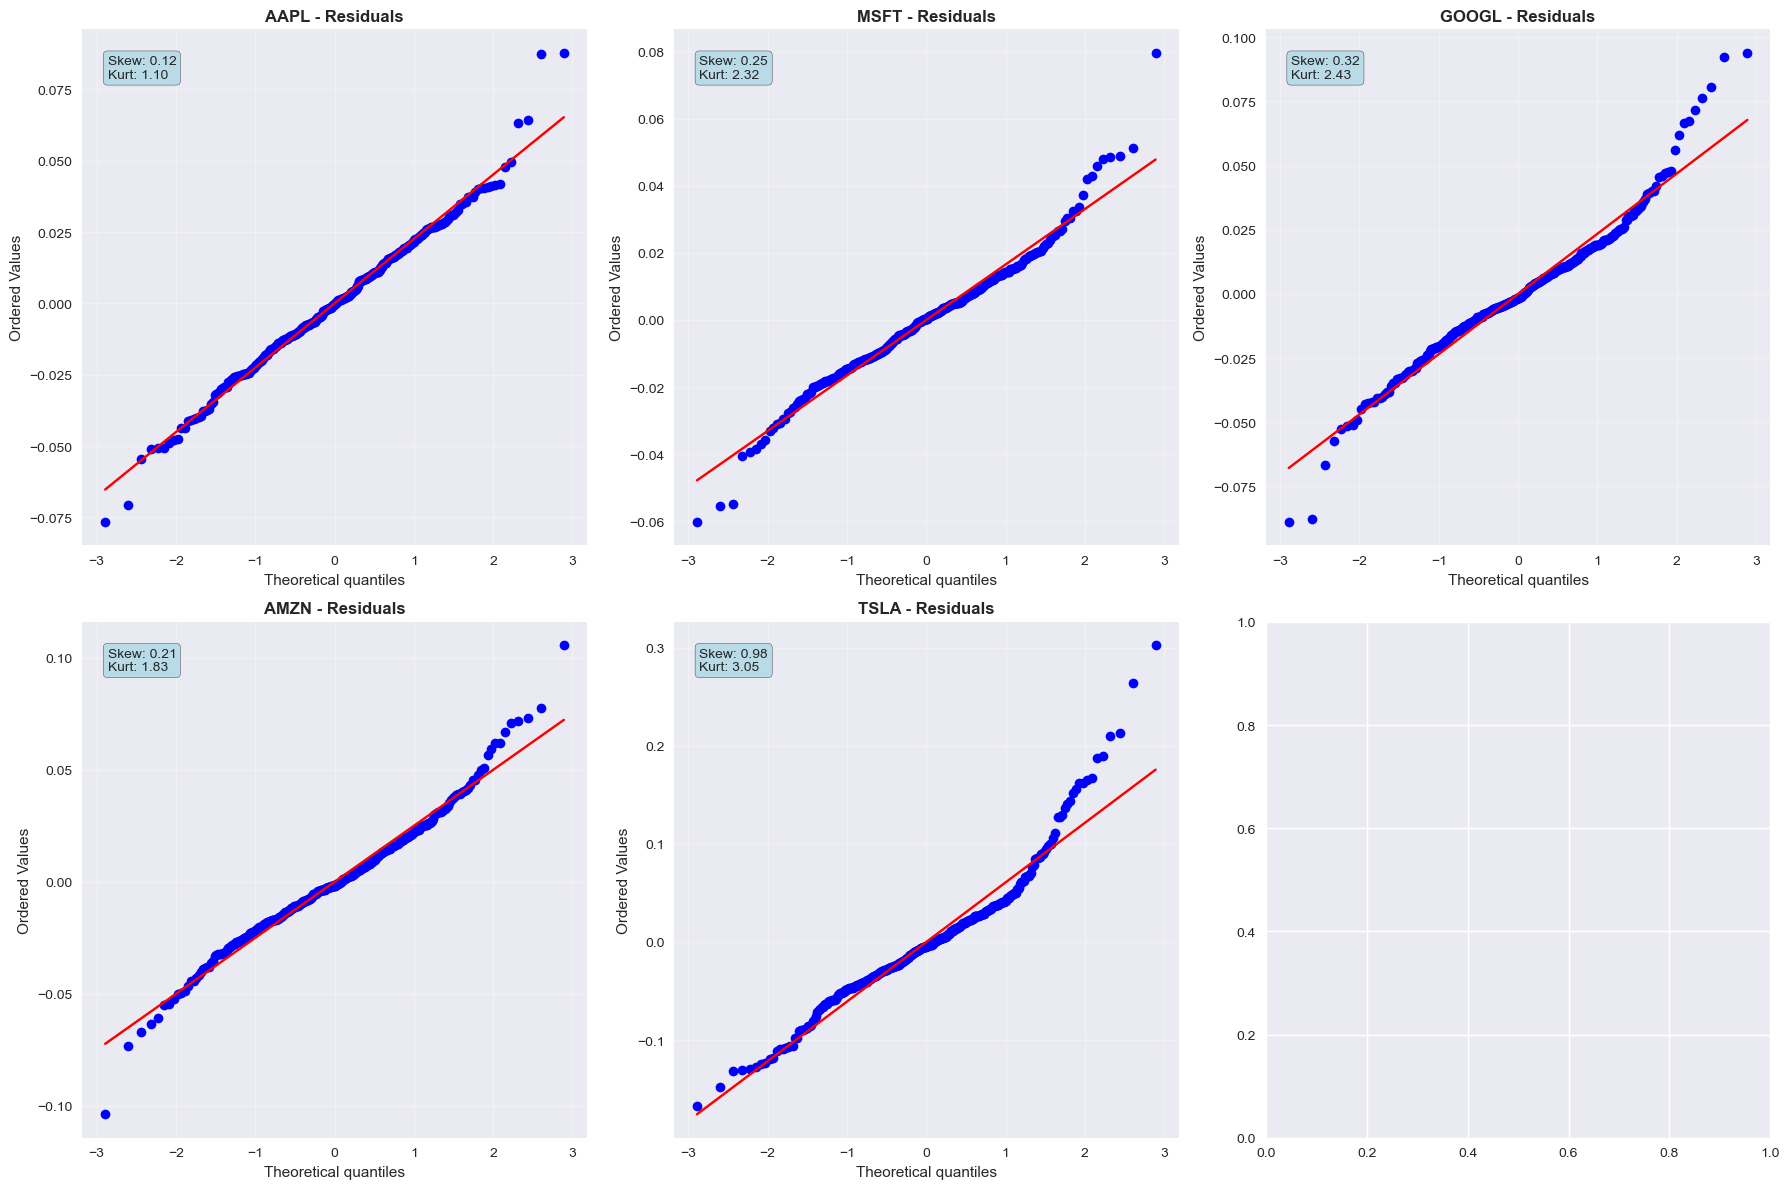

In [ ]:
# Visual comparison of normality improvements
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, stock in enumerate(sample_stocks[:6]):
    if stock in stocks.columns and i < 6:
        ax = axes[i]
        
        # Create side-by-side QQ plots
        stats.probplot(stocks[stock], dist="norm", plot=ax)
        ax.set_title(f'{stock} - Original Returns', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add statistics as text
        orig_skew = stocks[stock].skew()
        orig_kurt = stocks[stock].kurtosis()
        ax.text(0.05, 0.95, f'Skew: {orig_skew:.2f}\nKurt: {orig_kurt:.2f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add residuals QQ plots
fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
axes2 = axes2.flatten()

for i, stock in enumerate(sample_stocks[:6]):
    if stock in residuals.columns and i < 6:
        ax = axes2[i]
        
        stats.probplot(residuals[stock], dist="norm", plot=ax)
        ax.set_title(f'{stock} - Residuals', fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add statistics as text
        resid_skew = residuals[stock].skew()
        resid_kurt = residuals[stock].kurtosis()
        ax.text(0.05, 0.95, f'Skew: {resid_skew:.2f}\nKurt: {resid_kurt:.2f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()
